# Facial Expression Recognition Using SVM


## Imports

In [13]:
import random
import glob
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import dlib
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical

## Data Read

In [14]:
train_path = "../../Datasets/Emotion_Datasets/our_dataset/detected faces/train detected faces for each emotion/preprocessed/"

# Initialize lists to store image paths and images
train_image_paths = []
train_images = []
train_labels = []

# Create a mapping from string train_labels (emotions) to class numbers
emotion_to_class = {'anger': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6, 'disgust': 7}

# Loop through the subfolders
for folder_name in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder_name)
    if os.path.isdir(folder_path):
        image_files = glob.glob(os.path.join(folder_path, '*.jpg'))  # Modify the extension pattern if needed

        for image_path in image_files:
            # Extract emotion label from the folder name
            emotion_label = folder_name.lower()  # Assuming folder name represents the emotion label

            # Append image path to the list
            train_image_paths.append(image_path)

            # Convert the emotion label to class number using the mapping
            class_number = emotion_to_class.get(emotion_label.lower(), -1)  # -1 as a default value if the label is not in the mapping

            if class_number != -1:  # Consider only valid class numbers
                train_labels.append(class_number)

                # Read the image
                image = cv2.imread(image_path)
                train_images.append(image)


# Now you have a list of image paths (train_image_paths) and a list of train_images (train_images)
# print(train_images)
print(len(train_images))
print(len(train_image_paths))
print(train_labels)
print(len(train_labels))

181
181
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
181


In [15]:
test_path = "../../Datasets/Emotion_Datasets/our_dataset/detected faces/test detected faces for each emotion/preprocessed/"

# Initialize lists to store image paths and images
test_image_paths = []
test_images = []
test_labels = []

# Create a mapping from string test_labels (emotions) to class numbers
emotion_to_class = {'anger': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6, 'disgust': 7}

# Loop through the subfolders
for folder_name in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder_name)
    if os.path.isdir(folder_path):
        image_files = glob.glob(os.path.join(folder_path, '*.jpg'))  # Modify the extension pattern if needed

        for image_path in image_files:

            # Extract emotion label from the folder name
            emotion_label = folder_name.lower()  # Assuming folder name represents the emotion label

            # Append image path to the list
            test_image_paths.append(image_path)

            # Convert the emotion label to class number using the mapping
            class_number = emotion_to_class.get(emotion_label.lower(), -1)  # -1 as a default value if the label is not in the mapping

            if class_number != -1:  # Consider only valid class numbers
                test_labels.append(class_number)

                # Read the image
                image = cv2.imread(image_path)
                test_images.append(image)


# Now you have a list of image paths (test_image_paths) and a list of test_images (test_images)
# print(test_images)
print(len(test_images))
print(len(test_image_paths))
print(test_labels)
print(len(test_labels))

70
70
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
70


## Extract 68 Landmarks

In [16]:
def get_landmarks(image_path):

    landmark_points = []

    # Initialize the face detector and landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("../../shape_predictor_68_face_landmarks.dat")

    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = detector(gray)

    # Loop over the faces and save the extracted faces
    for face in faces:
        landmarks = predictor(gray, face)

        # Iterate through each of the 68 facial landmarks
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y

            # Store the landmark points in the list
            landmark_points.append((x, y))

    return landmark_points


In [17]:
sample = get_landmarks('../../Datasets/Emotion_Datasets/our_dataset/detected faces/train detected faces for each emotion/preprocessed/anger/25446.jpg_face.jpg')

print(sample)
print(len(sample))

[(11, 26), (13, 42), (16, 57), (19, 72), (25, 85), (34, 98), (45, 109), (58, 118), (72, 120), (86, 117), (97, 109), (106, 99), (113, 86), (118, 72), (121, 57), (124, 40), (124, 24), (22, 24), (32, 19), (43, 19), (54, 21), (64, 23), (80, 21), (90, 17), (100, 14), (110, 14), (118, 20), (73, 33), (74, 44), (74, 55), (75, 66), (60, 71), (67, 72), (74, 74), (81, 72), (87, 70), (35, 34), (42, 32), (49, 32), (56, 36), (49, 37), (41, 37), (87, 34), (94, 29), (101, 29), (107, 31), (102, 34), (94, 35), (51, 86), (59, 84), (68, 82), (73, 84), (79, 82), (87, 83), (94, 85), (87, 93), (79, 96), (73, 97), (67, 96), (59, 93), (54, 86), (67, 87), (73, 88), (79, 87), (91, 86), (79, 87), (73, 88), (68, 87)]
68


### Extract 68 landmarks for the whole dataset

In [18]:
train_landmark_points = []

# Iterate over each image path
for path in train_image_paths:
    landmarks = get_landmarks(path)
    train_landmark_points.append(landmarks)

# print(train_landmark_points)
print(len(train_landmark_points))

181


In [19]:
test_landmark_points = []

# Iterate over each image path
for path in test_image_paths:
    landmarks = get_landmarks(path)
    test_landmark_points.append(landmarks)

# print(test_landmark_points)
print(len(test_landmark_points))

70


## SVM Model

In [20]:
# Flatten the landmark points list before converting to a numpy array
X_train = np.array([point for sublist in train_landmark_points for point in sublist])

# Assuming each set has a different number of landmark points,
# find the maximum number of points among all sets
max_points_per_set = max(len(points) for points in train_landmark_points)

# Pad each set with zeros to make them of equal length
X_train_padded = [points + [(0, 0)] * (max_points_per_set - len(points)) for points in train_landmark_points]

# Reshape the array
X_train = np.array(X_train_padded).reshape((len(train_landmark_points), -1))

# Flatten the landmark points list before converting to a numpy array
X_test = np.array([point for sublist in test_landmark_points for point in sublist])

# Assuming each set has a different number of landmark points,
# find the maximum number of points among all sets
max_points_per_set = max(len(points) for points in test_landmark_points)

# Pad each set with zeros to make them of equal length
X_test_padded = [points + [(0, 0)] * (max_points_per_set - len(points)) for points in test_landmark_points]

# Reshape the array
X_test = np.array(X_test_padded).reshape((len(test_landmark_points), -1))


# Convert lists to numpy arrays
y_train = np.array(train_labels)
# Convert lists to numpy arrays
y_test = np.array(test_labels)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(181, 136)
(70, 136)
(181,)
(70,)


In [21]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear',probability=True) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(f"Prediction: {y_pred}")

Prediction: [2 1 6 4 4 1 1 1 2 7 4 2 2 1 4 5 6 4 2 5 2 1 5 4 1 6 7 2 2 5 3 3 5 3 5 3 5
 3 3 3 1 5 5 6 4 6 4 2 6 4 6 4 1 4 1 5 2 4 1 1 2 2 5 6 2 5 2 5 4 5]


## Results

In [22]:
# Step 4: Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

# Step 5: Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='weighted')
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test, y_pred,average='weighted')

print("\nAccuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Confusion Matrix:
[[4 2 0 2 0 1 1]
 [2 3 0 1 2 1 1]
 [0 0 7 0 3 0 0]
 [4 1 0 3 1 1 0]
 [0 4 0 1 4 1 0]
 [1 1 0 3 2 3 0]
 [1 3 0 3 2 1 0]]

Accuracy: 0.34
Precision: 0.35
Recall: 0.34
F1 Score: 0.34


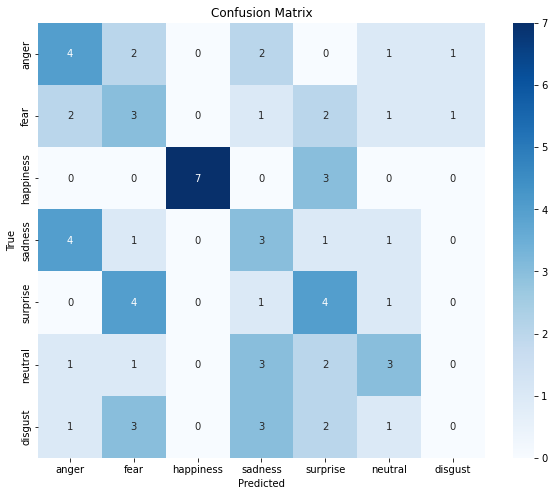

In [23]:
# Create a mapping from string labels (emotions) to class numbers
emotion_to_class = {'anger': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6, 'disgust': 7}

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=emotion_to_class.keys(), yticklabels=emotion_to_class.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Validation

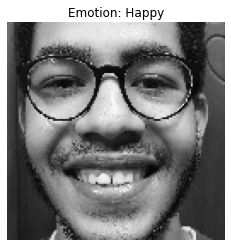

Input Data Shape: (1, 136)
Class Probabilities: [[0.0327527  0.11318602 0.46937208 0.0441661  0.22931148 0.04078823
  0.07042339]]
2
Predicted Emotion: happiness


In [25]:
# Load and preprocess a new image for testing
val_image_path = '../../Datasets/Emotion_Datasets/our_dataset/detected faces/validation detected faces for each emotion/preprocessed/happiness/497226.jpg_face.jpg'  # Replace with the path to your test image

# Read the image
val_image = cv2.imread(val_image_path)

# Plot the image
plt.imshow(cv2.cvtColor(val_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title("Emotion: Happy")
plt.axis('off')  # Turn off axis labels
plt.show()

val_landmarks = get_landmarks(val_image_path)

# Flatten the landmark points list before converting to a numpy array
val_landmarks_flatten = np.array([point for sublist in val_landmarks for point in sublist])


# Assuming each set has a different number of landmark points,
# find the maximum number of points among all sets
max_points_per_set = max(len(points) for points in val_landmarks)

# Pad each set with zeros to make them of equal length
validation_landmark_points_padded = [points + ((0, 0),) * (max_points_per_set - len(points)) for points in val_landmarks]

# Reshape the array
val_data = np.array(validation_landmark_points_padded).reshape((len(val_landmarks), -1))



# val_data = np.array(val_image)

# Expand dimensions to match the model's expected input shape (add batch dimension)
val_data = np.expand_dims(val_data, axis=0)

val_data = val_data.reshape(val_data.shape[0],-1)

# Print the shape of the input data
print("Input Data Shape:", val_data.shape)

# # Make predictions
# predictions = clf.predict(val_data)

# # Convert predictions to class labels
# predicted_class = np.argmax(predictions)

# Make probability predictions
class_probabilities = clf.predict_proba(val_data)

# Print class probabilities
print("Class Probabilities:", class_probabilities)

# Get the predicted class for each sample
predicted_class = np.argmax(class_probabilities, axis=1).item()

print(predicted_class)

# Map the predicted class index to the corresponding emotion label
emotion_labels = {0: 'anger', 1: 'fear', 2: 'happiness', 3: 'sadness', 4: 'surprise', 5: 'neutral', 6: 'disgust'}
predicted_emotion = emotion_labels[predicted_class]

# Print the predicted emotion
print(f'Predicted Emotion: {predicted_emotion}')

